# DARPA-ARC Notebook 5: Behavior Figures

## Figure 4: Group Summary

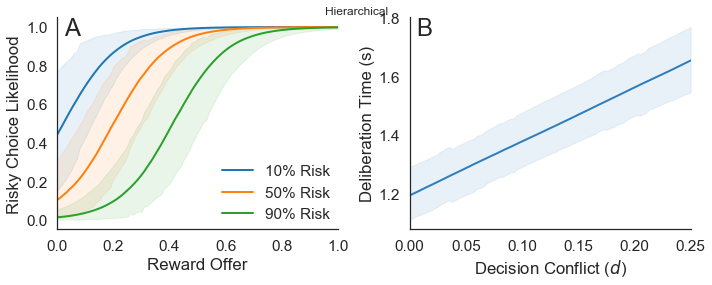

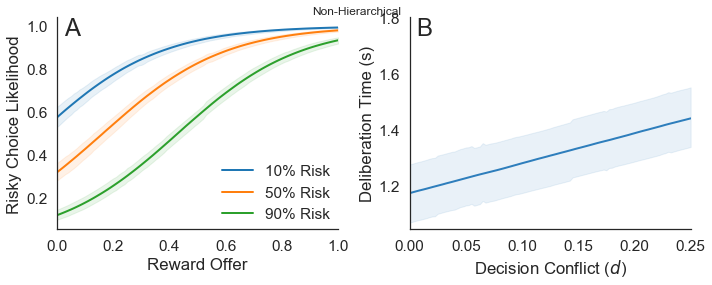

In [1]:
from my_settings import (os, op, np, read_csv, version, fs_dir,
                         root_dir, mri_dir, concat_sess_dir,
                         task,  subjects, stan_models, plt,
                         thresholds, nib, sm, spaces,
                         n_subj) 
import seaborn as sns
from stantools import load_fit, hdi
from stantools.stats import inv_logit, gamma_pdf
sns.set_style('white')
sns.set_context('notebook', font_scale=1.4)
np.random.seed(47404)
%matplotlib inline

for model_name in stan_models:
    #
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Load data.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~# 
    #
    ## Load model samples.
    f = os.path.join(root_dir, 'stan_results', '%s_%s_%s.pickle' % (version, task, model_name))
    samples = load_fit(f)
    #
    ## Extract samples.
    beta_mu = samples['beta_mu']
    a0_mu = samples['a0_mu']
    a1_mu = samples['a1_mu']
    shape = samples
    #
    ## Compute normalized scale.
    mu = samples['X'][:,-1].mean()
    sd = samples['X'][:,-1].std()
    x = np.linspace(0,1,101)
    z = (x - mu) / sd
    #
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Plotting.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~# 
    #
    fig = plt.figure(figsize=(10,4))
    fig.suptitle(model_name.replace('_',' ').title())
    #
    ## Compute low risk.
    low_risk = inv_logit(beta_mu[:,0] + np.outer(beta_mu[:,-1], z).T)
    low_risk_mode = np.median(low_risk, axis=1)
    low_risk_hdi = np.apply_along_axis(hdi, 1, low_risk)
    #
    ax = plt.subplot2grid((1,2),(0,0))
    ax.plot(x, low_risk_mode, lw=2, color='#1f77b4', label='10% Risk')
    ax.fill_between(x, *low_risk_hdi.T, color='#1f77b4', alpha=0.1)
    #
    ## Compute medium risk.
    med_risk = inv_logit(beta_mu[:,0] + beta_mu[:,1] + np.outer(beta_mu[:,-1], z).T)
    med_risk_mode = np.median(med_risk, axis=1)
    med_risk_hdi = np.apply_along_axis(hdi, 1, med_risk)
    #
    ax.plot(x, med_risk_mode, lw=2, color='#ff7f0e', label='50% Risk')
    ax.fill_between(x, *med_risk_hdi.T, color='#ff7f0e', alpha=0.1)
    #
    ## Compute high risk.
    high_risk = inv_logit(beta_mu[:,0] + beta_mu[:,2] + np.outer(beta_mu[:,-1], z).T)
    high_risk_mode = np.median(high_risk, axis=1)
    high_risk_hdi = np.apply_along_axis(hdi, 1, high_risk)
    #
    ax.plot(x, high_risk_mode, color='#2ca02c', lw=2, label='90% Risk')
    ax.fill_between(x, *high_risk_hdi.T, color='#2ca02c', alpha=0.1)
    #
    ## Add details.
    ax.set(xlim=(0,1), xlabel='Reward Offer', ylabel='Risky Choice Likelihood')
    ax.legend(loc=4, frameon=False, borderpad=0)
    ax.annotate('A', (0,0), (0.025, 1), 'axes fraction', fontsize=24, ha='left', va='top')
    #
    ## Extract gamma samples
    y = np.linspace(0,0.25,101)
    rt = a0_mu + np.outer(a1_mu, y).T
    rt_mode = np.median(rt, axis=1)
    rt_hdi = np.apply_along_axis(hdi, 1, rt)
    #
    ax = plt.subplot2grid((1,2),(0,1))
    ax.plot(y, rt_mode, lw=2, color='#2e7ebc')
    ax.fill_between(y, *rt_hdi.T, color='#2e7ebc', alpha=0.1)
    #
    ## Add details.
    ax.set(xlim=(0,0.25), xlabel=r'Decision Conflict ($d$)', 
           yticks=[1.2,1.4,1.6,1.8],ylabel='Deliberation Time (s)')
    ax.annotate('B', (0,0), (0.025, 1), 'axes fraction', fontsize=24, ha='left', va='top')
    #
    sns.despine()
    plt.tight_layout()
    plt.savefig(os.path.join(root_dir, 'plots', version, '%s_%s_group.png' % (task, model_name)), dpi=300)

## Figure 5: Individual Variability + Posterior Predictive Checks

ResponseType    0.721156
PPC             0.727574
dtype: float64
Observed    0.393648
PPC         0.430750
dtype: float64


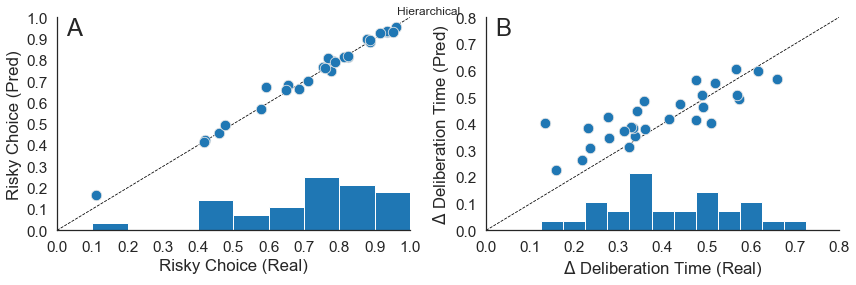

In [2]:
from my_settings import (os, op, np, read_csv, version, fs_dir,
                         root_dir, mri_dir, concat_sess_dir,
                         task,  subjects, stan_models, plt, 
                         thresholds, nib, sm, spaces,
                         n_subj, modality) 
import seaborn as sns
from stantools import load_fit
from stantools.stats import inv_logit, gamma_pdf
sns.set_style('white')
sns.set_context('notebook', font_scale=1.4)
np.random.seed(47404)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~# 

f = op.join(root_dir, 'stan_results/arc_%s_%s.csv' % (modality, version))
data = read_csv(f)
data = data[data.ResponseType.notnull()].reset_index(drop=True)

model_name = 'hierarchical'
#
## Load model samples.
f = os.path.join(root_dir, 'stan_results','%s_%s_%s.pickle' % (version, task, model_name))
samples = load_fit(f)
#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Prepare and visualize choice data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~# 
#
## Extract choice regression information.
X = samples['zX']
beta = samples['beta']
indices = samples['ix'] - 1
#
## Compute predicted choices.
ppc = []
for i in np.unique(indices):
    #
    ## Limit to subject.
    x = X[indices==i]
    #
    ## Compute likelihood of risky take.
    theta = inv_logit(x @ beta[:,i].T)
    #
    ## Simulate and average.
    y_pred = np.random.binomial(1, theta)
    ppc.append( y_pred.mean() )
#
## Compute average predicted choice.
gb = data.groupby('Subject').ResponseType.mean().reset_index()
gb['PPC'] = ppc
#
## Initialize canvas.
fig = plt.figure(figsize=(12,4))
fig.suptitle(model_name.replace('_',' ').title())
ax = plt.subplot2grid((1,2),(0,0))
#
## Scatterplot.
ax.scatter(gb.ResponseType, gb.PPC, s=110, color='#1f77b4', edgecolor='0.9', lw=0.8)
ax.plot(np.linspace(0,1),np.linspace(0,1),color='k',lw=0.8,linestyle='--',zorder=0)
print(gb.mean())
#
## Histogram.
bins = np.linspace(0,1,11)
counts, _ = np.histogram(gb.ResponseType, bins=bins)
counts = counts / counts.sum()
ax.bar(np.arange(0.05,1,0.1), counts, 0.1)
#
## Clean up.
ax.set(xlim=(0.0,1.0), xticks=np.linspace(0,1,11), xlabel='Risky Choice (Real)',
       ylim=(0.0,1.0), yticks=np.linspace(0,1,11), ylabel='Risky Choice (Pred)')
ax.annotate('A', (0,0), (0.025, 1), 'axes fraction', fontsize=24, ha='left', va='top')
#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Prepare and visualize reaction time data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~# 
#
## Extract reaction time regression information.
a0 = samples['a0']
a1 = samples['a1']
shape = samples['shape']
#
## Compute predicted reaction times.
ppc = []
for i in np.unique(indices):
    #
    ## Compute gamma parameters.
    mu_neutral = np.median(a0[:,i] + a1[:,i] * 0.00)
    mu_conflict = np.median(a0[:,i] + a1[:,i] * 0.25) # estimated max conflict
    mu_shape = np.median(shape[:,i])
    #
    ## Sample.
    x = np.arange(0, 3.5, 0.001)
    rt_neutral = x[gamma_pdf(x, mu_shape, mu_shape / mu_neutral).argmax()]
    rt_conflict = x[gamma_pdf(x, mu_shape, mu_shape / mu_conflict).argmax()]
    ppc.append( rt_conflict - rt_neutral )
#
## Store DDB information.
data['ddb'] = np.median(samples['ddb'], axis=0)
rt_neutral = data.groupby('Subject').apply(lambda x: x.ResponseTime[x.ddb < x.ddb.quantile(0.2)].mean())
rt_conflict = data.groupby('Subject').apply(lambda x: x.ResponseTime[x.ddb > x.ddb.quantile(0.8)].mean())
delta = (rt_conflict - rt_neutral).reset_index()
delta.columns = ['Subject','Observed']
delta['PPC'] = ppc
#
## Initialize canvas.
ax = plt.subplot2grid((1,2),(0,1))
#
## Scatterplot.
ax.scatter(delta.Observed, delta.PPC, s=110, color='#1f77b4', edgecolor='0.9', lw=0.8)
ax.plot(np.linspace(0,1),np.linspace(0,1),color='k',lw=0.8,linestyle='--',zorder=0)
print(delta.mean())
#
## Histogram.
bins = np.arange(0.0,0.85,0.05)
counts, _ = np.histogram(delta.Observed, bins=bins)
counts = counts / counts.sum()
ax.bar(np.arange(0.05, 0.85, 0.05), counts, 0.05)
#
## Clean up.
ax.set(xlim=(0.0,0.8), xticks=np.linspace(0,1,11), xlabel=r'$\Delta$ Deliberation Time (Real)',
       ylim=(0.0,0.8), yticks=np.linspace(0,1,11), ylabel=r'$\Delta$ Deliberation Time (Pred)',)
ax.annotate('B', (0,0), (0.025, 1), 'axes fraction', fontsize=24, ha='left', va='top')
#
sns.despine()
plt.tight_layout()
plt.savefig(op.join(root_dir, 'plots', version, '%s_%s_behavior.png' % (task, model_name)), dpi=300)